# 2048 Game Using Deep Q Learning

In this colab, I have tried to implement 2048 game using Deep Convolutional Network.
Deep Convolutional Network  accepts Game Matrix(nXn) as input. DCN has two convolutional layers, Expansion layer, Hidden layers, one Fully connected layer and last layer is a Dense layer with 4 outputs.




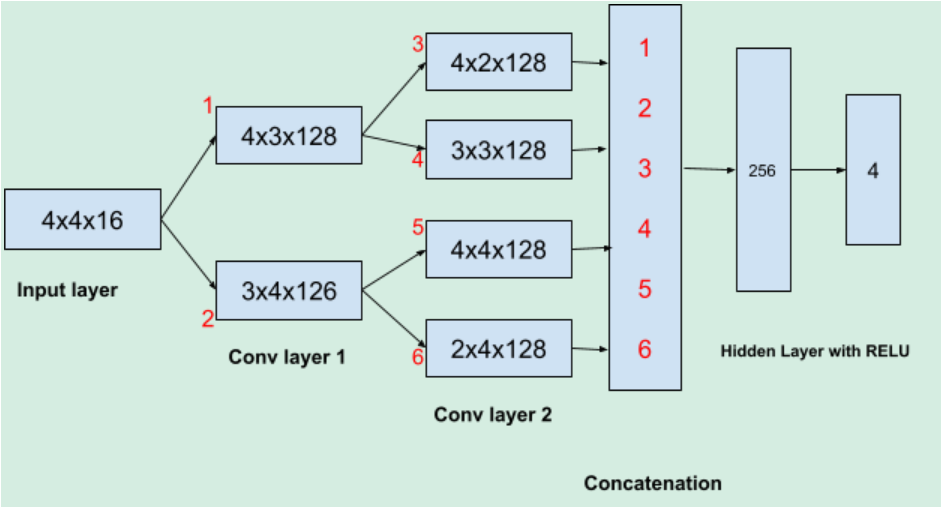

### Import Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

import numpy as np
from copy import deepcopy
import random 
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
print(tf.__version__)

2.7.0


### Defining the Logic of Game

In [ ]:
def reverse(mat):
    new=[]
    for i in range(len(mat)):
        new.append([])
        for j in range(len(mat[0])):
            new[i].append(mat[i][len(mat[0])-j-1])
    return new

def transpose(mat):
    new=[]
    for i in range(len(mat[0])):
        new.append([])
        for j in range(len(mat)):
            new[i].append(mat[j][i])
            
    return np.transpose(mat)

def cover_up(mat):
    new = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    done = False
    for i in range(4):
        count = 0
        for j in range(4):
            if mat[i][j]!=0:
                new[i][count] = mat[i][j]
                if j!=count:
                    done=True
                count+=1
    return (new,done)

In [ ]:
#initialize a new game matrix  of zixe n*n
def new_game(n):
    matrix = np.zeros([n,n])
    return matrix

#add 2 or 4 in the matrix
def add_two(m):
    empty_cells = []
    for i in range(len(m)):
        for j in range(len(m[0])):
            if(m[i][j]==0):
                empty_cells.append((i,j))
    if(len(empty_cells)==0):
        return m
    
    index_pair = empty_cells[random.randint(0,len(empty_cells)-1)]
  
    prob = random.random()
    if(prob>=0.9):
        m[index_pair[0]][index_pair[1]]=4
    else:
        m[index_pair[0]][index_pair[1]]=2
    return m

#to check state of the game
def game_state(mat):
  
    for i in range(len(mat)-1):
        for j in range(len(mat[0])-1): 
            if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
                return 'Game not over'
            
    for i in range(len(mat)): #check for any zero entries
        for j in range(len(mat[0])):
            if mat[i][j]==0:
                return 'Game not over'
            
    for k in range(len(mat)-1): #to check the left/right entries on the last row
        if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
            return 'Game not over'
        
    for j in range(len(mat)-1): #check up/down entries on last column
        if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
            return 'Game not over'
        
    return 'lose'



#up move
def up(game):
        game = transpose(game)
        game,done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = transpose(game)
        return (game,done,temp[2])
#left move
def left(game):
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        return (game,done,temp[2])

#down move
def down(game):
        game=reverse(transpose(game))
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=transpose(reverse(game))
        return (game,done,temp[2])

#right move
def right(game):
        game=reverse(game)
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=reverse(game)
        return (game,done,temp[2])

# Merge when two neighboring cells have the same value       
def merge(mat):
    done=False
    score = 0
    for i in range(4):
        for j in range(3):
            if mat[i][j]==mat[i][j+1] and mat[i][j]!=0:
                mat[i][j]*=2
                score += mat[i][j]   
                mat[i][j+1]=0
                done=True
    return (mat,done,score)


### Controls

In [ ]:
# Defining the dictionary for UP,DOWN, LEFT,RIGHT arrow movement
controls = {0:up,1:left,2:right,3:down}

### Hyper Parameters

In [ ]:
#hyper parameters for model training

#gamma for Q-learning
gamma = 0.9

#epsilon greedy approach
epsilon = 0.9

#Learning Rate
start_learning_rate = 0.0005


#to store states and lables of the game for training
#states of the game
replay_memory = list()

#labels of the states
replay_labels = list()

#capacity of memory
mem_capacity = 5000

### Important Functions
* Creating Empty Cell Function (Used in Reward)
* Convert Input Values of Matrix to power of 2

In [ ]:
#convert the input game matrix into corresponding power of 2 matrix.
def change_values(X):
    power_mat = np.zeros(shape=(1,4,4,16),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[0][i][j][0] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[0][i][j][power] = 1.0
    return power_mat        

#find the number of empty cells in the game matrix.
def findemptyCell(mat):
    count = 0
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                count+=1
    return count

In [ ]:
#first convolution layer depth
depth1 = 128

#second convolution layer depth
depth2 = 128

#batch size for batch gradient descent
batch_size = 512

#input units
input_units = 16

#fully connected layer neurons
hidden_units = 256 
#output neurons = number of moves
output_units = 4

## Building Model Architecture


* Loss = mean (square( Q(st,at) - (r + gamma x max(Q(st+1,a))) ) )
* Activation = RELU
* Optimizer = RMSProp

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#input data

tf_batch_dataset =tf.compat.v1.placeholder(tf.float32,shape=(batch_size,4,4,16))
tf_batch_labels  = tf.compat.v1.placeholder(tf.float32,shape=(batch_size,output_units))
single_dataset   = tf.compat.v1.placeholder(tf.float32,shape=(1,4,4,16))


#CONV LAYERS
#conv layer1 weights
def conv1_layer1_weights(shape=([1,2,input_units,depth1]), dtype=None):
    return tf.keras.initializers.TruncatedNormal(mean=0, stddev=0.01)(shape, dtype="float32")
def conv2_layer1_weights(shape=([2,1,input_units,depth1]), dtype=None):
    return tf.keras.initializers.TruncatedNormal(mean=0, stddev=0.01)(shape, dtype="float32")

#conv layer1 biases
def conv1_layer1_biases(shape=([1,2,input_units,depth1]), dtype=None):
    return tf.keras.initializers.TruncatedNormal(mean=0, stddev=0.01)(shape, dtype="float32")
def conv2_layer1_biases(shape=([2,1,input_units,depth1]), dtype=None):
    return tf.keras.initializers.TruncatedNormal(mean=0, stddev=0.01)(shape, dtype="float32")


#conv layer2 weights
def conv1_layer2_weights(shape=([1,2,depth1,depth2]), dtype=None):
    return tf.keras.initializers.TruncatedNormal(mean=0, stddev=0.01)(shape, dtype="float32")
def conv2_layer2_weights(shape=([2,1,depth1,depth2]), dtype=None):
    return tf.keras.initializers.TruncatedNormal(mean=0, stddev=0.01)(shape, dtype="float32")

#conv layer2 biases

def conv1_layer2_biases(shape=([1,2,depth1,depth2]), dtype=None):
    return tf.keras.initializers.TruncatedNormal(mean=0, stddev=0.01)(shape, dtype="float32")
def conv2_layer2_biases(shape=([2,1,depth1,depth2]), dtype=None):
    return tf.keras.initializers.TruncatedNormal(mean=0, stddev=0.01)(shape, dtype="float32")


#Fully connected Layers
expand_size = 2*4*depth2*2 + 3*3*depth2*2 + 4*3*depth1*2

initializer_layerfcw1 = keras.initializers.TruncatedNormal(mean=0, stddev=0.01)
fc_layer1_weights = tf.Variable(initializer_layerfcw1(shape=([expand_size,hidden_units])))

initializer_layerfcb1 = keras.initializers.TruncatedNormal(mean=0, stddev=0.01)
fc_layer1_biases = tf.Variable(initializer_layerfcb1(shape=([1,hidden_units])))

initializer_layerfcw2 = keras.initializers.TruncatedNormal(mean=0, stddev=0.01)
fc_layer2_weights = tf.Variable(initializer_layerfcw2(shape=([hidden_units,output_units])))

initializer_layerfcb2 = keras.initializers.TruncatedNormal(mean=0, stddev=0.01)
fc_layer2_biases = tf.Variable(initializer_layerfcb2(shape=([1,output_units])))


def make_model(input_shape):
    #Input
    input=keras.Input(shape=input_shape[1:] ,name='input',batch_size=input_shape[0])
 
    #layer1    

    x=layers.Conv2D(kernel_size=(1,2),filters=128,strides=1,padding="valid",name="conv1",kernel_initializer=conv1_layer1_weights)(input)
    y1=layers.Activation("relu")(x)
    y2=layers.Conv2D(kernel_size=(2,1),filters=128,strides=1,padding="valid",name="conv2",kernel_initializer=conv2_layer1_weights)(input)
    y3=layers.Activation("relu")(y2)

   #layer2
    y4=tf.keras.layers.Conv2D(kernel_size=(1,2),filters=128,strides=1,padding="valid",name="conv11",kernel_initializer=conv1_layer2_weights)(y1)
    y5=layers.Activation("relu")(y4)
    y6=tf.keras.layers.Conv2D(kernel_size=(2,1),filters=128,strides=1,padding="valid",name="conv12",kernel_initializer=conv2_layer2_weights)(y1)
    y7=layers.Activation("relu")(y6)
    y8=tf.keras.layers.Conv2D(kernel_size=(1,2),filters=128,strides=1,padding="valid",name="conv21",kernel_initializer=conv1_layer2_weights)(y3)
    y9=layers.Activation("relu")(y8)
    y10=tf.keras.layers.Conv2D(kernel_size=(2,1),filters=128,strides=1,padding="valid",name="conv22",kernel_initializer=conv2_layer2_weights)(y3)
    y11=layers.Activation("relu")(y10)

    #get shapes of all activations
    shape1 = y1.shape.as_list()
    shape2 = y3.shape.as_list()
    shape11 = y5.shape.as_list()
    shape12 = y7.shape.as_list()
    shape21 = y9.shape.as_list()
    shape22 = y11.shape.as_list()
  
    #expansion
    hidden1 = tf.reshape(y1,[shape1[0],shape1[1]*shape1[2]*shape1[3]])
    hidden2 = tf.reshape(y3,[shape2[0],shape2[1]*shape2[2]*shape2[3]])
    hidden11 = tf.reshape(y5,[shape11[0],shape11[1]*shape11[2]*shape11[3]])
    hidden12 = tf.reshape(y7,[shape12[0],shape12[1]*shape12[2]*shape12[3]])
    hidden21 = tf.reshape(y9,[shape21[0],shape21[1]*shape21[2]*shape21[3]])
    hidden22 = tf.reshape(y11,[shape22[0],shape22[1]*shape22[2]*shape22[3]])
 
    #concatenation
    hidden = tf.concat([hidden1,hidden2,hidden11,hidden12,hidden21,hidden22],axis=1)

    #full connected layers
    # hidden=layers.Dense(units=256,kernel_initializer=fc_layer1_weights,bias_initializer=fc_layer1_biases,activation="relu")(hidden)
    hidden=layers.Dense(units=256,activation="relu")(hidden)
    
    #output layer

    output=layers.Dense(4,activation=None)(hidden)
  
    return keras.Model(input,output)


model1=make_model(input_shape=(1, 4, 4, 16))
model2=make_model(input_shape=(512, 4, 4, 16))

# Model prediction for single example
single_output = model1(single_dataset)

# Model prediction for batch data
logits = model2(tf_batch_dataset)



Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Defining Loss Function

In [ ]:
loss = tf.square(tf.subtract(tf_batch_labels,logits))
loss = tf.reduce_sum(loss,axis=1,keep_dims=True)
loss = tf.reduce_mean(loss)/2.0

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Defining RMS Optimizer

In [ ]:
#optimizer
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(float(start_learning_rate), global_step, 1000, 0.90, staircase=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(1, 4, 4, 16)]      0           []                               
                                                                                                  
 conv1 (Conv2D)                 (1, 4, 3, 128)       4224        ['input[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (1, 3, 4, 128)       4224        ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (1, 4, 3, 128)       0           ['conv1[0][0]']                  
                                                                                              

##Model Training

In [ ]:
#loss
J = []

#scores
scores = []

#to store final weights
final_weights = {}

#number of episodes
M = 10000

In [15]:
with tf.Session() as session:
  
    tf.global_variables_initializer().run()
    print("Initialized")
    
    global epsilon
    global replay_labels
    global replay_memory

    #for episode with max score
    maximum = -1
    episode = -1
    
    #total_iters 
    total_iters = 1
    
    #number of back props
    back=0
    
    for ep in range(M):
        global board
        board = new_game(4) ## initilizing the game board
        add_two(board)
        add_two(board)
        
        #whether episode finished or not
        finish = 'Game not over'
        
        #total_score of this episode
        total_score = 0
        
        #iters per episode
        local_iters = 1
        
        while(finish=='Game not over'):
            prev_board = deepcopy(board)

            #store prev max
            prev_max = np.max(prev_board)

            #get the required move for this state
            state = deepcopy(board)
           
            state = change_values(state)
          
            state = np.array(state,dtype = np.float32).reshape(1,4,4,16)
           
            feed_dict = {single_dataset:state}
        
            control_scores = session.run(single_output,feed_dict=feed_dict)
 
            #find the move with max Q value (sorting in decreasing order)
            control_buttons = np.flip(np.argsort(control_scores),axis=1)
         
            #copy the Q-values as labels
            labels = deepcopy(control_scores[0])
       
            #generate random number for epsilon greedy approach
            num = random.uniform(0,1)
   
            #num is less epsilon generate random move
            if(num<epsilon):
                #find legal moves
                legal_moves = list()
                for i in range(4):
                    temp_board = deepcopy(prev_board)
                   
                    temp_board,_,_ = controls[i](temp_board)
                    if(np.array_equal(temp_board,prev_board)):
                        continue
                    else:
                        legal_moves.append(i)
                if(len(legal_moves)==0):
                    finish = 'lose'
                    continue
                
                #generate random move.
                con = random.sample(legal_moves,1)[0]
             
                #apply the move
                temp_state = deepcopy(prev_board)
                temp_state,_,score = controls[con](temp_state)
                total_score += score
                finish = game_state(temp_state)
                
                #get number of merges
                empty1 = findemptyCell(prev_board)
                empty2 = findemptyCell(temp_state)
                
                if(finish=='Game not over'):
                    temp_state = add_two(temp_state)

                board = deepcopy(temp_state)

                #get next max after applying the move
                next_max = np.max(temp_state)

               #Current Reward = number of merges + log(new max,2)
                #reward math.log(next_max,2)*0.1 if next_max is higher than prev max
                labels[con] = (math.log(next_max,2))*0.1
                
                if(next_max==prev_max):
                    labels[con] = 0
                
                #reward is also the number of merges
                labels[con] += (empty2-empty1)
                
                #get the next state max Q-value
                temp_state = change_values(temp_state)
                temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                feed_dict = {single_dataset:temp_state}
                temp_scores = session.run(single_output,feed_dict=feed_dict)
                    
                max_qvalue = np.max(temp_scores)
                
                #final labels add gamma*max_qvalue
                labels[con] = (labels[con] + gamma*max_qvalue)
            
            #generate the the max predicted move
            else:
                for con in control_buttons[0]:
                    prev_state = deepcopy(prev_board)
                    
                    #apply the LEGAl Move with max q_value
                    temp_state,_,score = controls[con](prev_state)
                    
                    #if illegal move label = 0
                    if(np.array_equal(prev_board,temp_state)):
                        labels[con] = 0
                        continue
                        
                    #get number of merges
                    empty1 = findemptyCell(prev_board)
                    empty2 = findemptyCell(temp_state)

                    temp_state = add_two(temp_state)
                    board = deepcopy(temp_state)
                    total_score += score

                    next_max = np.max(temp_state)
                    
                    #reward
                    labels[con] = (math.log(next_max,2))*0.1
                    if(next_max==prev_max):
                        labels[con] = 0
                    
                    labels[con] += (empty2-empty1)

                    #get next max qvalue
                    temp_state = change_values(temp_state)
                    temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                    feed_dict = {single_dataset:temp_state}
                    temp_scores = session.run(single_output,feed_dict=feed_dict)

                    max_qvalue = np.max(temp_scores)

                    #final labels
                    labels[con] = (labels[con] + gamma*max_qvalue)
                    break
                    
                if(np.array_equal(prev_board,board)):
                    finish = 'lose'
            
            #decrease the epsilon value
            if((ep>5000) or (epsilon>0.1 and total_iters%2500==0)):
                epsilon = epsilon/1.005
                
           
            #change the matrix values and store them in memory
            prev_state = deepcopy(prev_board)
            prev_state = change_values(prev_state)
            prev_state = np.array(prev_state,dtype=np.float32).reshape(1,4,4,16)
            # print(replay_labels)
            replay_labels.append(labels)
            replay_memory.append(prev_state)
            
            
            #back-propagation
            if(len(replay_memory)>=mem_capacity):
                back_loss = 0
                batch_num = 0
                z = list(zip(replay_memory,replay_labels))
                np.random.shuffle(z)
                np.random.shuffle(z)
                replay_memory,replay_labels = zip(*z)
                
                for i in range(0,len(replay_memory),batch_size):
                    if(i + batch_size>len(replay_memory)):
                        break
                        
                    batch_data = deepcopy(replay_memory[i:i+batch_size])
                    batch_labels = deepcopy(replay_labels[i:i+batch_size])
                    
                    batch_data = np.array(batch_data,dtype=np.float32).reshape(batch_size,4,4,16)
                    batch_labels = np.array(batch_labels,dtype=np.float32).reshape(batch_size,output_units)
                
                    feed_dict = {tf_batch_dataset: batch_data, tf_batch_labels: batch_labels}
                    _,l = session.run([optimizer,loss],feed_dict=feed_dict)
                  
                    back_loss += l 
                    
                    print("Mini-Batch - {} Back-Prop : {}, Loss : {}".format(batch_num,back,l))
                    batch_num +=1
                back_loss /= batch_num
                J.append(back_loss)
                
                #store the weights in a dictionary
                final_weights['conv1_layer1_weights'] = session.run(conv1_layer1_weights())
                final_weights['conv1_layer2_weights'] = session.run(conv1_layer2_weights())
                final_weights['conv2_layer1_weights'] = session.run(conv2_layer1_weights())
                final_weights['conv2_layer2_weights'] = session.run(conv2_layer2_weights())
                final_weights['conv1_layer1_biases'] = session.run(conv1_layer1_biases())
                final_weights['conv1_layer2_biases'] = session.run(conv1_layer2_biases())
                final_weights['conv2_layer1_biases'] = session.run(conv2_layer1_biases())
                final_weights['conv2_layer2_biases'] = session.run(conv2_layer2_biases())
                final_weights['fc_layer1_weights'] = session.run(fc_layer1_weights)
                final_weights['fc_layer2_weights'] = session.run(fc_layer2_weights)
                final_weights['fc_layer1_biases'] = session.run(fc_layer1_biases)
                final_weights['fc_layer2_biases'] = session.run(fc_layer2_biases)
                
                #number of back-props
                back+=1
                
                #make new memory 
                replay_memory = list()
                replay_labels = list()
                
            
            if(local_iters%400==0):
                print("Episode : {}, Score : {}, Iters : {}, Finish : {}".format(ep,total_score,local_iters,finish))
            
            local_iters += 1
            total_iters += 1
            
        scores.append(total_score)
        if ep%5==0:
          print("Episode {} finished with score {}, result : {} board : {}, epsilon  : {}, learning rate : {} ".format(ep,total_score,finish,board,epsilon,session.run(learning_rate)))
          print()
        
        if((ep+1)%1000==0):
            print("Maximum Score : {} ,Episode : {}".format(maximum,episode))    
            print("Loss : {}".format(J[len(J)-1]))
            print()
            
        if(maximum<total_score):
            maximum = total_score
            episode = ep

    print("Maximum Score : {} ,Episode : {}".format(maximum,episode))    

Streaming output truncated to the last 5000 lines.

Mini-Batch - 0 Back-Prop : 119, Loss : 0.38847389817237854
Mini-Batch - 1 Back-Prop : 119, Loss : 0.36304253339767456
Mini-Batch - 2 Back-Prop : 119, Loss : 0.428275465965271
Mini-Batch - 3 Back-Prop : 119, Loss : 0.4230368435382843
Mini-Batch - 4 Back-Prop : 119, Loss : 0.3486279547214508
Mini-Batch - 5 Back-Prop : 119, Loss : 0.4061506390571594
Mini-Batch - 6 Back-Prop : 119, Loss : 0.43235206604003906
Mini-Batch - 7 Back-Prop : 119, Loss : 0.3584100604057312
Mini-Batch - 8 Back-Prop : 119, Loss : 0.3933515250682831
Episode 4960 finished with score 1260.0, result : lose board : [[  8.  16.   2.  16.]
 [  2.  64. 128.   8.]
 [  4.  16.   4.   2.]
 [  8.   4.   2.   4.]], epsilon  : 0.2718865274268254, learning rate : 0.0004500000213738531 

Episode 4965 finished with score 444.0, result : lose board : [[ 2.  8. 16.  2.]
 [ 4.  2.  4. 32.]
 [ 2.  4. 32.  4.]
 [ 4. 32.  4.  2.]], epsilon  : 0.2718865274268254, learning rate : 0.0004500

## Store the Trained Weights in a file

In [ ]:
path = r'/content/gdrive/Shareddrives/CMPE_260/Tamanna_DQN/Final_Weights'
weights = ['conv1_layer1_weights','conv1_layer2_weights','conv2_layer1_weights','conv2_layer2_weights','fc_layer1_weights','fc_layer1_biases','fc_layer2_weights','fc_layer2_biases']
for w in weights:
    flatten = final_weights[w].reshape(-1,1)
    file = open(path + '\\' + w +'.csv','w')
    file.write('Sno,Weight\n')
    for i in range(flatten.shape[0]):
        file.write(str(i) +',' +str(flatten[i][0])+'\n') 
    file.close()
    print(w + " written!")

conv1_layer1_weights written!
conv1_layer2_weights written!
conv2_layer1_weights written!
conv2_layer2_weights written!
fc_layer1_weights written!
fc_layer1_biases written!
fc_layer2_weights written!
fc_layer2_biases written!
